In [10]:
import json
import re
import pandas as pd

JSON_PATH = "rr_results_full_json.json"  # <-- change to your file name/path

def load_json_lenient(path: str):
    """
    Loads a JSON list of objects. If the file has the common '}{' missing comma issue,
    it tries a minimal repair so you can proceed in a notebook.
    """
    txt = open(path, "r", encoding="utf-8").read().strip()

    try:
        return json.loads(txt)
    except json.JSONDecodeError:
        # Minimal repair: insert commas between }{
        repaired = re.sub(r"}\s*{", "},\n{", txt)
        # Also ensure list commas between objects: ] not handled; assume list already []
        return json.loads(repaired)

records = load_json_lenient(JSON_PATH)
df = pd.DataFrame(records)

# --- basic derived fields ---
df["slots_computed"] = df["cores"] * df["machines"]

# normalize to wall-seconds (so speedup differences don’t break comparisons)
df["mean_response_wall_s"] = (df["mean_response_ms"] / df["speedup"]) / 1000.0
df["p95_response_wall_s"]  = (df["p95_response_ms"]  / df["speedup"]) / 1000.0
df["mean_wait_wall_s"]     = (df["mean_wait_ms"]     / df["speedup"]) / 1000.0

# --- sanity checks ---
bad_slots = df[df["slots_computed"] != df["total_slots_at_end"]][
    ["run_id","dataset","cores","machines","slots_computed","total_slots_at_end"]
]

print("Rows where cores*machines != total_slots_at_end:", len(bad_slots))
display(bad_slots.head(20))

df = df.sort_values(["dataset", "total_slots_at_end", "quantum_ms"]).reset_index(drop=True)
display(df.head(10))


Rows where cores*machines != total_slots_at_end: 0


,run_id,dataset,cores,machines,slots_computed,total_slots_at_end


,run_id,dataset_file,cores,machines,dataset,quantum_ms,speedup,jobs,mean_response_ms,p50_response_ms,p95_response_ms,p99_response_ms,mean_wait_ms,avg_slices_per_job,total_slots_at_end,slots_computed,mean_response_wall_s,p95_response_wall_s,mean_wait_wall_s
0,8a41c5376b,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,10,2000.0,1000,2.233421e+08,2.400900e+08,2.801075e+08,2.805921e+08,2.233416e+08,56.098,4,4,111.671073,140.05375,111.670795
1,4dc9196f9f,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,20,2000.0,1000,1.083706e+08,1.157820e+08,1.368865e+08,1.371821e+08,1.083701e+08,28.293,4,4,54.185318,68.44325,54.185040
2,c46b7cdc07,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,50,2000.0,1000,4.183418e+07,4.472300e+07,5.292640e+07,5.311202e+07,4.183362e+07,11.610,4,4,20.917088,26.46320,20.916810
3,f041e7f06f,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,100,2000.0,1000,1.995105e+07,2.143200e+07,2.597230e+07,2.614604e+07,1.995050e+07,6.065,4,4,9.975527,12.98615,9.975249
4,6f29bdb41a,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,200,2000.0,1000,1.190583e+07,1.285000e+07,1.579850e+07,1.596008e+07,1.190527e+07,3.299,4,4,5.952915,7.89925,5.952637
5,e535b84f38,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,500,2000.0,1000,4.646664e+06,5.199000e+06,7.174100e+06,7.374140e+06,4.646107e+06,1.601,4,4,2.323332,3.58705,2.323054
6,d180f8a8e1,dataset_rr_batch_largeq_opt_1k.csv,2,8,large,10,20000.0,1000,1.707070e+09,1.833820e+09,2.147849e+09,2.151220e+09,1.707069e+09,56.098,16,16,85.353500,107.39245,85.353472
7,a356155b26,dataset_rr_batch_largeq_opt_1k.csv,2,8,large,20,20000.0,1000,7.739592e+08,8.281000e+08,9.723410e+08,9.749002e+08,7.739586e+08,28.293,16,16,38.697958,48.61705,38.697930
8,409344e8d1,dataset_rr_batch_largeq_opt_1k.csv,2,8,large,50,20000.0,1000,3.093944e+08,3.328600e+08,3.913600e+08,3.926002e+08,3.093939e+08,11.610,16,16,15.469722,19.56800,15.469694
9,bbedee9d0c,dataset_rr_batch_largeq_opt_1k.csv,2,8,large,100,20000.0,1000,1.586534e+08,1.702900e+08,2.022810e+08,2.035202e+08,1.586528e+08,6.065,16,16,7.932668,10.11405,7.932640


In [11]:
import matplotlib.pyplot as plt

def plot_vs_quantum(df_sub: pd.DataFrame, y: str, title: str, ylog: bool = True):
    plt.figure()
    for slots, g in df_sub.groupby("slots_computed"):
        g = g.sort_values("quantum_ms")
        plt.plot(g["quantum_ms"], g[y], marker="o", label=f"{slots} slots")

    plt.xscale("log")  # quantum = 1,10,20,... works well on log scale
    if ylog:
        plt.yscale("log")

    plt.xlabel("Quantum (ms, log scale)")
    plt.ylabel(y)
    plt.title(title)
    plt.legend()
    plt.show()


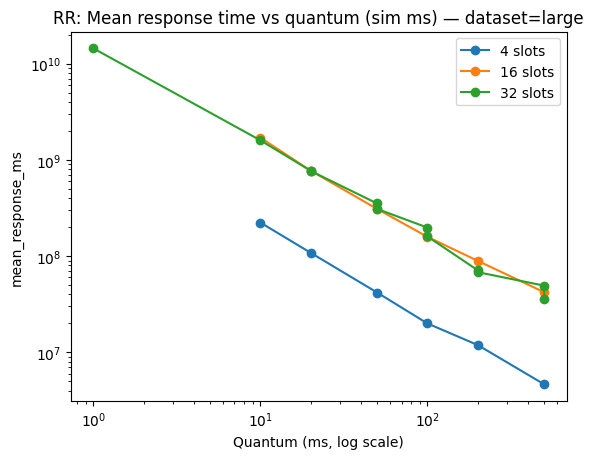

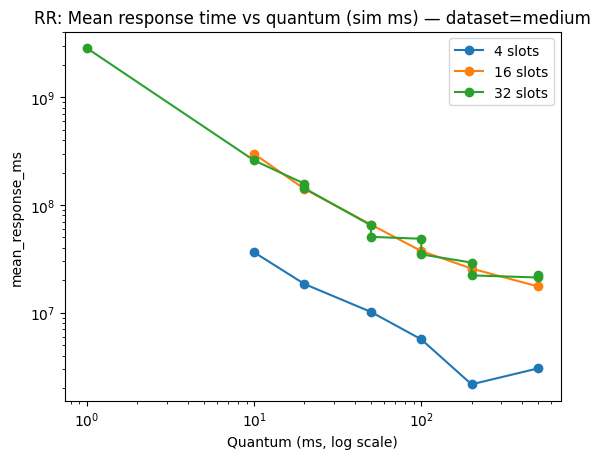

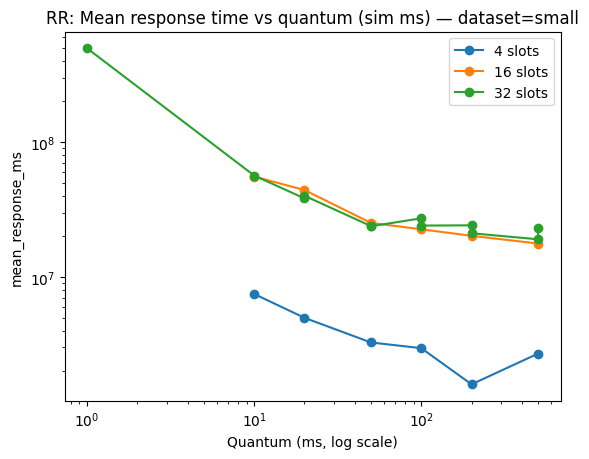

In [12]:
for dataset, g in df.groupby("dataset"):
    plot_vs_quantum(
        g,
        y="mean_response_ms",
        title=f"RR: Mean response time vs quantum (sim ms) — dataset={dataset}",
        ylog=True
    )

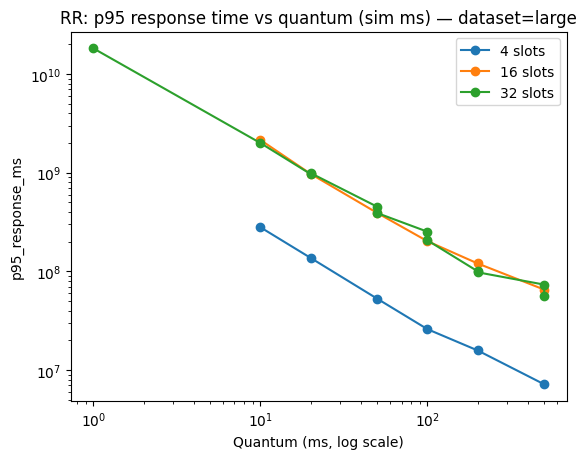

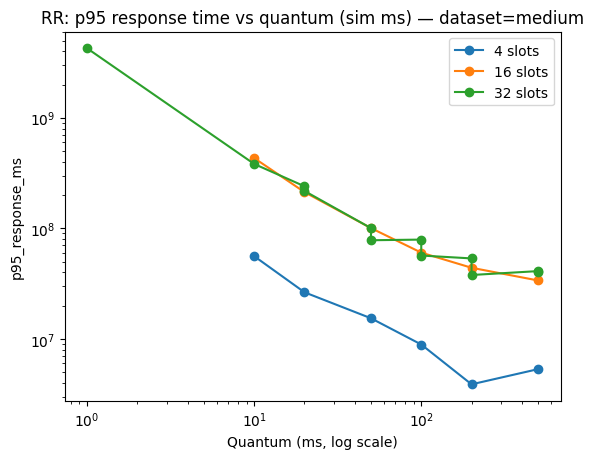

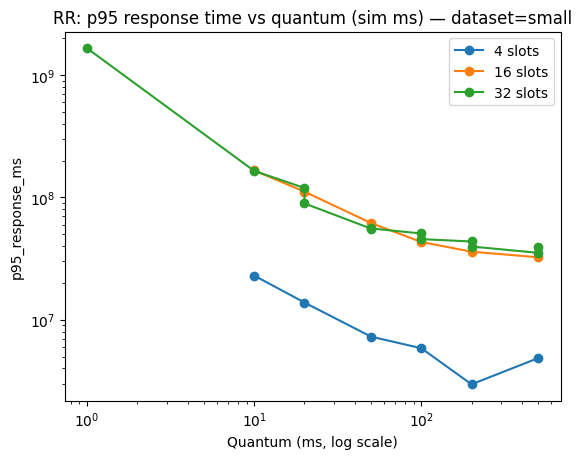

In [13]:
for dataset, g in df.groupby("dataset"):
    plot_vs_quantum(
        g,
        y="p95_response_ms",
        title=f"RR: p95 response time vs quantum (sim ms) — dataset={dataset}",
        ylog=True
    )


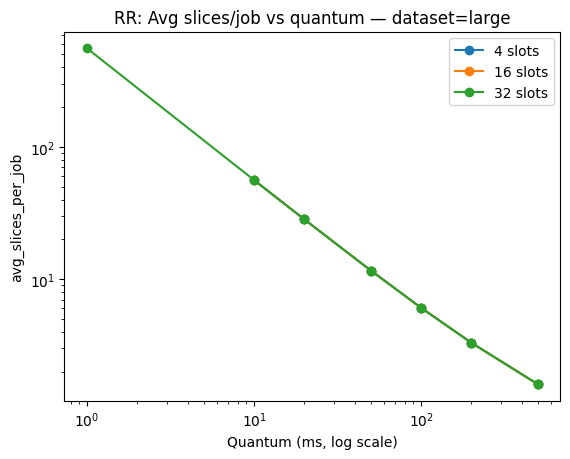

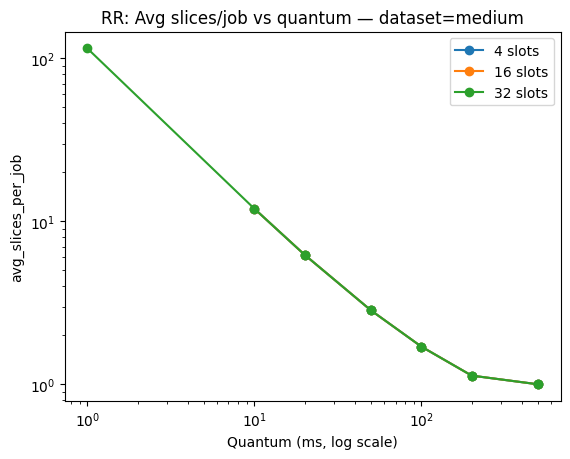

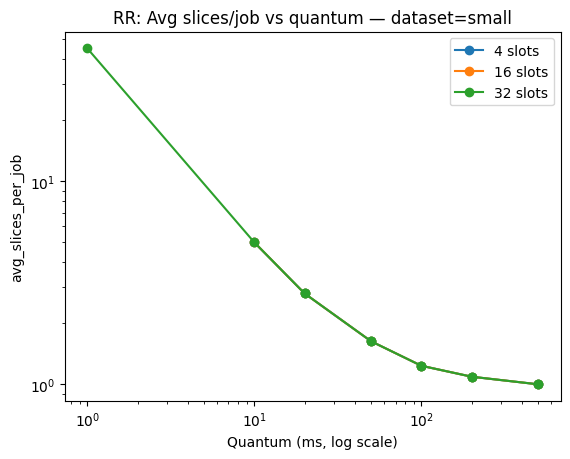

In [14]:
for dataset, g in df.groupby("dataset"):
    plot_vs_quantum(
        g,
        y="avg_slices_per_job",
        title=f"RR: Avg slices/job vs quantum — dataset={dataset}",
        ylog=True
    )


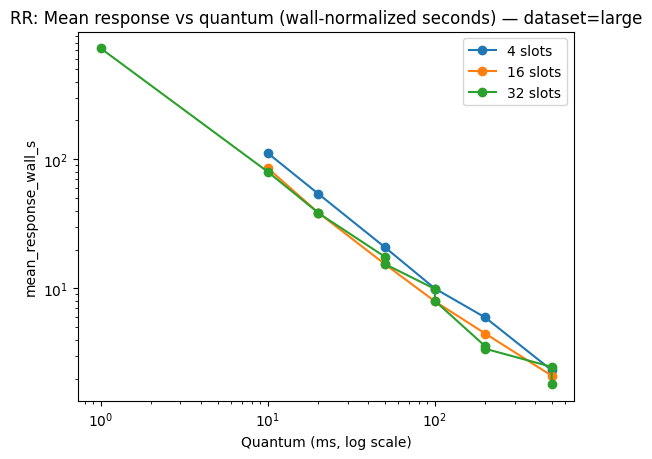

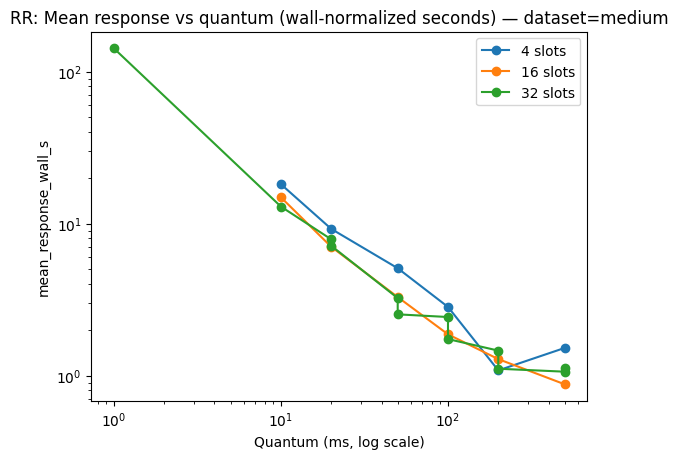

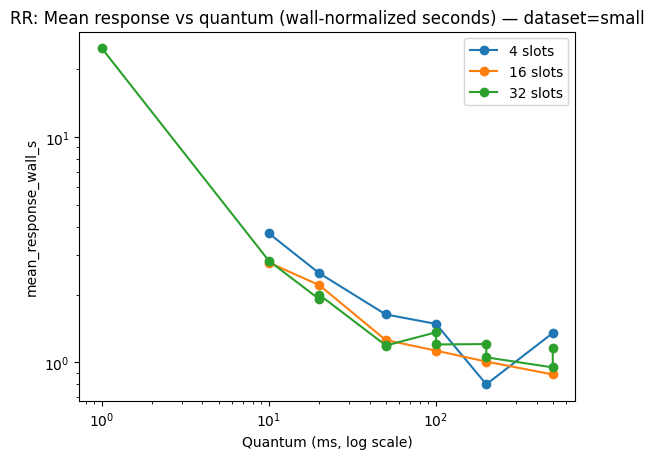

In [15]:
for dataset, g in df.groupby("dataset"):
    plot_vs_quantum(
        g,
        y="mean_response_wall_s",
        title=f"RR: Mean response vs quantum (wall-normalized seconds) — dataset={dataset}",
        ylog=True
    )


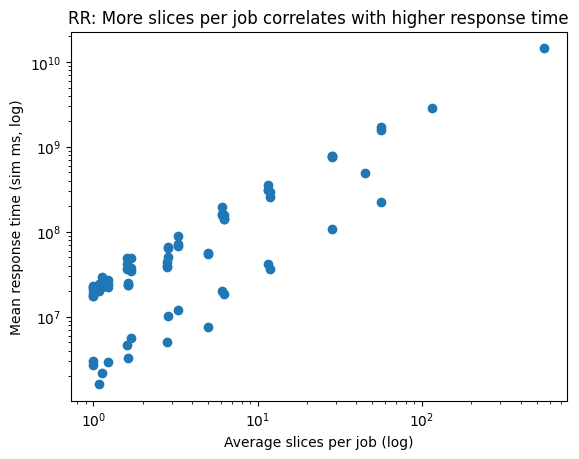

In [16]:
plt.figure()
plt.scatter(df["avg_slices_per_job"], df["mean_response_ms"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Average slices per job (log)")
plt.ylabel("Mean response time (sim ms, log)")
plt.title("RR: More slices per job correlates with higher response time")
plt.show()


In [19]:
import numpy as np
import os
import pandas as pd

RESULTS_DIR = "/results"  # change if needed

def ensure_derived_columns(df: pd.DataFrame, results_dir: str = RESULTS_DIR) -> pd.DataFrame:
    df = df.copy()

    # slots
    if "slots" not in df.columns:
        if "machines" in df.columns and "cores" in df.columns:
            df["slots"] = df["machines"].astype(int) * df["cores"].astype(int)

    # total_slices
    if "total_slices" not in df.columns:
        if "avg_slices_per_job" in df.columns and "jobs" in df.columns:
            df["total_slices"] = df["avg_slices_per_job"].astype(float) * df["jobs"].astype(float)

    # run_time_wall_s (optional; requires jobs CSV files)
    if "run_time_wall_s" not in df.columns:
        df["run_time_wall_s"] = np.nan
        if "run_id" in df.columns and "speedup" in df.columns:
            for i, row in df.iterrows():
                rid = row["run_id"]
                spd = float(row["speedup"])
                jobs_path = os.path.join(results_dir, f"results_jobs_{rid}.csv")
                if os.path.exists(jobs_path):
                    jobs = pd.read_csv(jobs_path)
                    if not jobs.empty and "finish_time_ms" in jobs.columns and "arrival_time_ms" in jobs.columns:
                        makespan_sim_ms = float(jobs["finish_time_ms"].max() - jobs["arrival_time_ms"].min())
                        df.at[i, "run_time_wall_s"] = (makespan_sim_ms / spd) / 1000.0

    return df

df = ensure_derived_columns(df, RESULTS_DIR)
df.head()


,run_id,dataset_file,cores,machines,dataset,quantum_ms,speedup,jobs,mean_response_ms,p50_response_ms,...,mean_wait_ms,avg_slices_per_job,total_slots_at_end,slots_computed,mean_response_wall_s,p95_response_wall_s,mean_wait_wall_s,slots,total_slices,run_time_wall_s
0,8a41c5376b,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,10,2000.0,1000,223342146.0,240090000.0,...,2.233416e+08,56.098,4,4,111.671073,140.05375,111.670795,4,56098.0,NaN
1,4dc9196f9f,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,20,2000.0,1000,108370636.0,115782000.0,...,1.083701e+08,28.293,4,4,54.185318,68.44325,54.185040,4,28293.0,NaN
2,c46b7cdc07,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,50,2000.0,1000,41834176.0,44723000.0,...,4.183362e+07,11.610,4,4,20.917088,26.46320,20.916810,4,11610.0,NaN
3,f041e7f06f,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,100,2000.0,1000,19951054.0,21432000.0,...,1.995050e+07,6.065,4,4,9.975527,12.98615,9.975249,4,6065.0,NaN
4,6f29bdb41a,dataset_rr_batch_largeq_opt_1k.csv,2,2,large,200,2000.0,1000,11905830.0,12850000.0,...,1.190527e+07,3.299,4,4,5.952915,7.89925,5.952637,4,3299.0,NaN


In [20]:
def compare_configs(df, cfg_a, cfg_b, name_a, name_b):
    df = ensure_derived_columns(df, RESULTS_DIR)

    a = df[(df["machines"]==cfg_a[0]) & (df["cores"]==cfg_a[1])].copy()
    b = df[(df["machines"]==cfg_b[0]) & (df["cores"]==cfg_b[1])].copy()

    key = ["dataset", "quantum_ms"]

    wanted = [
        "machines","cores","slots","total_slots_at_end",
        "run_time_wall_s","total_slices","avg_slices_per_job",
        "mean_response_ms","mean_wait_ms",
    ]

    # only keep columns that actually exist
    keep_a = key + [c for c in wanted if c in a.columns]
    keep_b = key + [c for c in wanted if c in b.columns]

    a = a[keep_a].rename(columns={c: f"{c}_{name_a}" for c in keep_a if c not in key})
    b = b[keep_b].rename(columns={c: f"{c}_{name_b}" for c in keep_b if c not in key})

    m = pd.merge(a, b, on=key, how="outer").sort_values(key).reset_index(drop=True)

    # deltas where both exist
    for metric in ["run_time_wall_s","total_slices","avg_slices_per_job","mean_response_ms","mean_wait_ms"]:
        ca = f"{metric}_{name_a}"
        cb = f"{metric}_{name_b}"
        if ca in m.columns and cb in m.columns:
            m[f"delta_{metric}({name_b}-{name_a})"] = m[cb] - m[ca]

    return m


In [22]:
CFG_8x2  = (8,2)
CFG_8x4  = (8,4)
CFG_16x2 = (16,2)

tab_8x2_vs_8x4  = compare_configs(df, CFG_8x2,  CFG_8x4,  "8x2", "8x4")
tab_16x2_vs_8x4 = compare_configs(df, CFG_16x2, CFG_8x4,  "16x2", "8x4")

display(tab_8x2_vs_8x4)
display(tab_16x2_vs_8x4)


,dataset,quantum_ms,machines_8x2,cores_8x2,slots_8x2,total_slots_at_end_8x2,run_time_wall_s_8x2,total_slices_8x2,avg_slices_per_job_8x2,mean_response_ms_8x2,...,run_time_wall_s_8x4,total_slices_8x4,avg_slices_per_job_8x4,mean_response_ms_8x4,mean_wait_ms_8x4,delta_run_time_wall_s(8x4-8x2),delta_total_slices(8x4-8x2),delta_avg_slices_per_job(8x4-8x2),delta_mean_response_ms(8x4-8x2),delta_mean_wait_ms(8x4-8x2)
0,large,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,556522.0,556.522,1.447664e+10,1.447664e+10,NaN,NaN,NaN,NaN,NaN
1,large,10,8.0,2.0,16.0,16.0,NaN,56098.0,56.098,1.707070e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,large,20,8.0,2.0,16.0,16.0,NaN,28293.0,28.293,7.739592e+08,...,NaN,28293.0,28.293,7.726684e+08,7.726678e+08,NaN,0.0,0.0,-1290800.0,-1290800.0
3,large,50,8.0,2.0,16.0,16.0,NaN,11610.0,11.610,3.093944e+08,...,NaN,11610.0,11.610,3.528810e+08,3.528805e+08,NaN,0.0,0.0,43486600.0,43486600.0
4,large,100,8.0,2.0,16.0,16.0,NaN,6065.0,6.065,1.586534e+08,...,NaN,6065.0,6.065,1.980167e+08,1.980161e+08,NaN,0.0,0.0,39363300.0,39363300.0
5,large,200,8.0,2.0,16.0,16.0,NaN,3299.0,3.299,8.938422e+07,...,NaN,3299.0,3.299,7.132076e+07,7.132020e+07,NaN,0.0,0.0,-18063460.0,-18063460.0
6,large,500,8.0,2.0,16.0,16.0,NaN,1601.0,1.601,4.213956e+07,...,NaN,1601.0,1.601,4.933656e+07,4.933600e+07,NaN,0.0,0.0,7197000.0,7197000.0
7,medium,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,115122.0,115.122,2.848142e+09,2.848142e+09,NaN,NaN,NaN,NaN,NaN
8,medium,10,8.0,2.0,16.0,16.0,NaN,11957.0,11.957,2.981053e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,medium,20,8.0,2.0,16.0,16.0,NaN,6233.0,6.233,1.410091e+08,...,NaN,6233.0,6.233,1.578248e+08,1.578247e+08,NaN,0.0,0.0,16815680.0,16815680.0


,dataset,quantum_ms,machines_16x2,cores_16x2,slots_16x2,total_slots_at_end_16x2,run_time_wall_s_16x2,total_slices_16x2,avg_slices_per_job_16x2,mean_response_ms_16x2,...,run_time_wall_s_8x4,total_slices_8x4,avg_slices_per_job_8x4,mean_response_ms_8x4,mean_wait_ms_8x4,delta_run_time_wall_s(8x4-16x2),delta_total_slices(8x4-16x2),delta_avg_slices_per_job(8x4-16x2),delta_mean_response_ms(8x4-16x2),delta_mean_wait_ms(8x4-16x2)
0,large,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,556522.0,556.522,1.447664e+10,1.447664e+10,NaN,NaN,NaN,NaN,NaN
1,large,10,16.0,2.0,32.0,32.0,NaN,56098.0,56.098,1.600251e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,large,20,16.0,2.0,32.0,32.0,NaN,28293.0,28.293,7.685603e+08,...,NaN,28293.0,28.293,7.726684e+08,7.726678e+08,NaN,0.0,0.0,4108020.0,4108020.0
3,large,50,16.0,2.0,32.0,32.0,NaN,11610.0,11.610,3.095510e+08,...,NaN,11610.0,11.610,3.528810e+08,3.528805e+08,NaN,0.0,0.0,43330020.0,43330020.0
4,large,100,16.0,2.0,32.0,32.0,NaN,6065.0,6.065,1.601212e+08,...,NaN,6065.0,6.065,1.980167e+08,1.980161e+08,NaN,0.0,0.0,37895500.0,37895500.0
5,large,200,16.0,2.0,32.0,32.0,NaN,3299.0,3.299,6.813612e+07,...,NaN,3299.0,3.299,7.132076e+07,7.132020e+07,NaN,0.0,0.0,3184640.0,3184640.0
6,large,500,16.0,2.0,32.0,32.0,NaN,1601.0,1.601,3.611950e+07,...,NaN,1601.0,1.601,4.933656e+07,4.933600e+07,NaN,0.0,0.0,13217060.0,13217060.0
7,medium,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,115122.0,115.122,2.848142e+09,2.848142e+09,NaN,NaN,NaN,NaN,NaN
8,medium,10,16.0,2.0,32.0,32.0,NaN,11957.0,11.957,2.591594e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,medium,20,16.0,2.0,32.0,32.0,NaN,6233.0,6.233,1.431647e+08,...,NaN,6233.0,6.233,1.578248e+08,1.578247e+08,NaN,0.0,0.0,14660120.0,14660120.0


In [ ]:
plot_two_configs(
    df,
    cfg_a=(16,2), cfg_b=(8,4),
    name_a="16m×2c (32 slots)", name_b="8m×4c (32 slots)",
    fig_title="Comparison 2: 16 machines × 2 cores vs 8 machines × 4 cores (same total slots)"
)


In [ ]:
CFG_8x2  = (8,2)
CFG_8x4  = (8,4)
CFG_16x2 = (16,2)

tab_8x2_vs_8x4  = compare_configs(df, CFG_8x2,  CFG_8x4,  "8x2", "8x4")
tab_16x2_vs_8x4 = compare_configs(df, CFG_16x2, CFG_8x4,  "16x2", "8x4")

display(tab_8x2_vs_8x4)
display(tab_16x2_vs_8x4)
